In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
# from Klein_Gordon_model_tf import Sampler, Klein_Gordon
import timeit
import os
os.environ["KMP_WARNINGS"] = "FALSE" 

import scipy
import scipy.io
import time


def u(x):
    """
    :param x: x = (t, x)
    """
    return x[:, 1:2] * np.cos(5 * np.pi * x[:, 0:1]) + (x[:, 0:1] * x[:, 1:2])**3

def u_tt(x):
    return - 25 * np.pi**2 * x[:, 1:2] * np.cos(5 * np.pi * x[:, 0:1]) + 6 * x[:,0:1] * x[:,1:2]**3

def u_xx(x):
    return np.zeros((x.shape[0], 1)) +  6 * x[:,1:2] * x[:,0:1]**3

def f(x, alpha, beta, gamma, k):
    return u_tt(x) + alpha * u_xx(x) + beta * u(x) + gamma * u(x)**k

def operator(u, t, x, alpha, beta, gamma, k,  sigma_t=1.0, sigma_x=1.0):
    u_t = tf.gradients(u, t)[0] / sigma_t
    u_x = tf.gradients(u, x)[0] / sigma_x
    u_tt = tf.gradients(u_t, t)[0] / sigma_t
    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    residual = u_tt + alpha * u_xx + beta * u + gamma * u**k
    return residual


In [2]:


class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

class Klein_Gordon:
    # Initialize the class
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma, k, model, stiff_ratio):
        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Klein_Gordon constant
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.beta = tf.constant(beta, dtype=tf.float32)
        self.gamma = tf.constant(gamma, dtype=tf.float32)
        self.k = tf.constant(k, dtype=tf.float32)

        # Mode
        self.model = model

        # Record stiff ratio
        self.stiff_ratio = stiff_ratio

        # Adaptive re-weighting constant
        self.rate = 0.9
        self.adaptive_constant_ics_val = np.array(1.0)
        self.adaptive_constant_bcs_val = np.array(1.0)

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        if model in ['M3', 'M4']:
            # Initialize encoder weights and biases
            self.encoder_weights_1 = self.xavier_init([2, layers[1]])
            self.encoder_biases_1 = self.xavier_init([1, layers[1]])

            self.encoder_weights_2 = self.xavier_init([2, layers[1]])
            self.encoder_biases_2 = self.xavier_init([1, layers[1]])

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.adaptive_constant_ics_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_ics_val.shape)
        self.adaptive_constant_bcs_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs_val.shape)

        # Evaluate predictions
        self.u_ics_pred = self.net_u(self.t_ics_tf, self.x_ics_tf)
        self.u_t_ics_pred = self.net_u_t(self.t_ics_tf, self.x_ics_tf)
        self.u_bc1_pred = self.net_u(self.t_bc1_tf, self.x_bc1_tf)
        self.u_bc2_pred = self.net_u(self.t_bc2_tf, self.x_bc2_tf)

        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf)
        self.r_pred = self.net_r(self.t_r_tf, self.x_r_tf)

        # Boundary loss and Initial loss
        self.loss_ic_u = tf.reduce_mean(tf.square(self.u_ics_tf - self.u_ics_pred))
        self.loss_ic_u_t = tf.reduce_mean(tf.square(self.u_t_ics_pred))
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred - self.u_bc1_tf))
        self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred - self.u_bc2_tf))

        self.loss_bcs = self.adaptive_constant_bcs_tf * (self.loss_bc1 + self.loss_bc2)
        self.loss_ics = self.adaptive_constant_ics_tf * (self.loss_ic_u + self.loss_ic_u_t)
        self.loss_u = self.loss_bcs + self.loss_ics

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_pred - self.r_tf))

        # Total loss
        self.loss = self.loss_res + self.loss_u

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # Logger
        self.loss_u_log = []
        self.loss_r_log = []
        self.saver = tf.train.Saver()

        # Generate dicts for gradients storage
        self.dict_gradients_res_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_bcs_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_ics_layers = self.generate_grad_dict(self.layers)

        # Gradients Storage
        self.grad_res = []
        self.grad_ics = []
        self.grad_bcs = []

        for i in range(len(self.layers) - 1):
            self.grad_res.append(tf.gradients(self.loss_res, self.weights[i])[0])
            self.grad_bcs.append(tf.gradients(self.loss_bcs, self.weights[i])[0])
            self.grad_ics.append(tf.gradients(self.loss_ics, self.weights[i])[0])

        # Store the adaptive constant
        self.adaptive_constant_ics_log = []
        self.adaptive_constant_bcs_log = []

        # Compute the adaptive constant
        self.adaptive_constant_ics_list = []
        self.adaptive_constant_bcs_list = []
        
        self.max_grad_res_list = []
        self.mean_grad_bcs_list = []
        self.mean_grad_ics_list = []

        for i in range(len(self.layers) - 1):
            self.max_grad_res_list.append(tf.reduce_max(tf.abs(self.grad_res[i]))) 
            self.mean_grad_bcs_list.append(tf.reduce_mean(tf.abs(self.grad_bcs[i])))
            self.mean_grad_ics_list.append(tf.reduce_mean(tf.abs(self.grad_ics[i])))
        
        self.max_grad_res = tf.reduce_max(tf.stack(self.max_grad_res_list))
        self.mean_grad_bcs = tf.reduce_mean(tf.stack(self.mean_grad_bcs_list))
        self.mean_grad_ics = tf.reduce_mean(tf.stack(self.mean_grad_ics_list))
        
        self.adaptive_constant_bcs = self.max_grad_res / self.mean_grad_bcs
        self.adaptive_constant_ics = self.max_grad_res / self.mean_grad_ics

        # # Stiff Ratio
        # if self.stiff_ratio:
        #     self.Hessian, self.Hessian_ics, self.Hessian_bcs, self.Hessian_res = self.get_H_op()
        #     self.eigenvalues, _ = tf.linalg.eigh(self.Hessian)
        #     self.eigenvalues_ics, _ = tf.linalg.eigh(self.Hessian_ics)
        #     self.eigenvalues_bcs, _ = tf.linalg.eigh(self.Hessian_bcs)
        #     self.eigenvalues_res, _ = tf.linalg.eigh(self.Hessian_res)

        #     self.eigenvalue_log = []
        #     self.eigenvalue_ics_log = []
        #     self.eigenvalue_bcs_log = []
        #     self.eigenvalue_res_log = []

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Create dictionary to store gradients
    def generate_grad_dict(self, layers):
        num = len(layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict

    # Save gradients
    def save_gradients(self, tf_dict):
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_ics_value , grad_bcs_value, grad_res_value= self.sess.run([self.grad_ics[i],
                                                                            self.grad_bcs[i],
                                                                            self.grad_res[i]],
                                                                            feed_dict=tf_dict)

            # save gradients of loss_res and loss_bcs
            self.dict_gradients_ics_layers['layer_' + str(i + 1)].append(grad_ics_value.flatten())
            self.dict_gradients_bcs_layers['layer_' + str(i + 1)].append(grad_bcs_value.flatten())
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res_value.flatten())
        return None

    # Compute the Hessian
    def flatten(self, vectors):
        return tf.concat([tf.reshape(v, [-1]) for v in vectors], axis=0)

    def get_Hv(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss, self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_ics(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_ics, self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_bcs(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_bcs, self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_res(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_res,
                                                   self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod,
                                          self.weights))
        return Hv_op

    def get_H_op(self):
        self.P = self.flatten(self.weights).get_shape().as_list()[0]
        H = tf.map_fn(self.get_Hv, tf.eye(self.P, self.P),
                      dtype='float32')
        H_ics = tf.map_fn(self.get_Hv_ics, tf.eye(self.P, self.P),
                          dtype='float32')
        H_bcs = tf.map_fn(self.get_Hv_bcs, tf.eye(self.P, self.P),
                          dtype='float32')
        H_res = tf.map_fn(self.get_Hv_res, tf.eye(self.P, self.P),
                          dtype='float32')

        return H, H_ics, H_bcs, H_res

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H):
        if self.model in ['M1', 'M2']:
            num_layers = len(self.layers)
            for l in range(0, num_layers - 2):
                W = self.weights[l]
                b = self.biases[l]
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
            W = self.weights[-1]
            b = self.biases[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

        if self.model in ['M3', 'M4']:
            num_layers = len(self.layers)
            encoder_1 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_1), self.encoder_biases_1))
            encoder_2 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_2), self.encoder_biases_2))

            for l in range(0, num_layers - 2):
                W = self.weights[l]
                b = self.biases[l]
                H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
                    tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_2)

            W = self.weights[-1]
            b = self.biases[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

    # Forward pass for u
    def net_u(self, t, x):
        u = self.forward_pass(tf.concat([t, x], 1))
        return u

    def net_u_t(self, t, x):
        u_t = tf.gradients(self.net_u(t, x), t)[0] / self.sigma_t
        return u_t

    # Forward pass for residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x,
                                 self.alpha, self.beta, self.gamma, self.k,
                                 self.sigma_t, self.sigma_x)
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    # Trains the model by minimizing the MSE loss
################################################################################################################

    def train(self, nIter=10000):

        start_time = timeit.default_timer()
        batch_size = 350
        # Fetch boundary mini-batches
        X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size)
        X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
        X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)

        batch_size = 1000

        # Fetch residual mini-batch
        X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

        # Define a dictionary for associating placeholders with data
        tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                    self.u_ics_tf: u_ics_batch,
                    self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                    self.u_bc1_tf: u_bc1_batch,
                    self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                    self.u_bc2_tf: u_bc2_batch,
                    self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                    self.r_tf: f_res_batch,
                    self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val,
                    self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val}

        # Run the Tensorflow session to minimize the loss

        for it in range(nIter):
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value, loss_r_value = self.sess.run([self.loss_u, self.loss_res], tf_dict)

                # Compute and Print adaptive weights during training
                # Compute the adaptive constant
                adaptive_constant_ics_val, adaptive_constant_bcs_val = self.sess.run( [self.adaptive_constant_ics, self.adaptive_constant_bcs], tf_dict)
                # Print adaptive weights during training
                self.adaptive_constant_ics_val = adaptive_constant_ics_val * ( 1.0 - self.rate) + self.rate * self.adaptive_constant_ics_val
                self.adaptive_constant_bcs_val = adaptive_constant_bcs_val * ( 1.0 - self.rate) + self.rate * self.adaptive_constant_bcs_val

                # # Store loss and adaptive weights
                # self.loss_u_log.append(loss_u_value)
                # self.loss_r_log.append(loss_r_value)

                # self.adaptive_constant_ics_log.append(self.adaptive_constant_ics_val)
                # self.adaptive_constant_bcs_log.append(self.adaptive_constant_bcs_val)

                print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, Time: %.2f' %  (it, loss_value, loss_u_value, loss_r_value, elapsed))
                print("constant_ics_val: {:.3f}, constant_bcs_val: {:.3f}".format(  self.adaptive_constant_ics_val,  self.adaptive_constant_bcs_val))
                start_time = timeit.default_timer()

            # # Compute the eigenvalues of the Hessian of losses
            # if self.stiff_ratio:
            #     if it % 1000 == 0:
            #         print("Eigenvalues information stored ...")
            #         eigenvalues, eigenvalues_ics, eigenvalues_bcs, eigenvalues_res = self.sess.run([self.eigenvalues,
            #                                                                                         self.eigenvalues_ics,
            #                                                                                         self.eigenvalues_bcs,
            #                                                                                         self.eigenvalues_res], tf_dict)
            #         self.eigenvalue_log.append(eigenvalues)
            #         self.eigenvalue_ics_log.append(eigenvalues_bcs)
            #         self.eigenvalue_bcs_log.append(eigenvalues_bcs)
            #         self.eigenvalue_res_log.append(eigenvalues_res)

            # # Store gradients
            # if it % 10000 == 0:
            #     self.save_gradients(tf_dict)
            #     print("Gradients information stored ...")

################################################################################################################
    def trainmb(self, nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size)
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)

            # Fetch residual mini-batch
            X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.u_ics_tf: u_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.u_bc1_tf: u_bc1_batch,
                       self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                       self.u_bc2_tf: u_bc2_batch,
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                       self.r_tf: f_res_batch,
                       self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val,
                       self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val}

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value, loss_r_value = self.sess.run([self.loss_u, self.loss_res], tf_dict)

                # Compute and Print adaptive weights during training
                if self.model in ['M2', 'M4']:
                    # Compute the adaptive constant
                    adaptive_constant_ics_val, adaptive_constant_bcs_val = self.sess.run( [self.adaptive_constant_ics, self.adaptive_constant_bcs], tf_dict)
                    # Print adaptive weights during training
                    self.adaptive_constant_ics_val = adaptive_constant_ics_val * (1.0 - self.rate) + self.rate * self.adaptive_constant_ics_val
                    self.adaptive_constant_bcs_val = adaptive_constant_bcs_val * ( 1.0 - self.rate) + self.rate * self.adaptive_constant_bcs_val

                # # Store loss and adaptive weights
                # self.loss_u_log.append(loss_u_value)
                # self.loss_r_log.append(loss_r_value)

                # self.adaptive_constant_ics_log.append(self.adaptive_constant_ics_val)
                # self.adaptive_constant_bcs_log.append(self.adaptive_constant_bcs_val)

                print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, Time: %.2f' %(it, loss_value, loss_u_value, loss_r_value, elapsed))
                print("constant_ics_val: {:.3f}, constant_bcs_val: {:.3f}".format( self.adaptive_constant_ics_val, self.adaptive_constant_bcs_val))
                start_time = timeit.default_timer()

            # # Compute the eigenvalues of the Hessian of losses
            # if self.stiff_ratio:
            #     if it % 1000 == 0:
            #         print("Eigenvalues information stored ...")
            #         eigenvalues, eigenvalues_ics, eigenvalues_bcs, eigenvalues_res = self.sess.run([self.eigenvalues,
            #                                                                                         self.eigenvalues_ics,
            #                                                                                         self.eigenvalues_bcs,
            #                                                                                         self.eigenvalues_res], tf_dict)
            #         self.eigenvalue_log.append(eigenvalues)
            #         self.eigenvalue_ics_log.append(eigenvalues_bcs)
            #         self.eigenvalue_bcs_log.append(eigenvalues_bcs)
            #         self.eigenvalue_res_log.append(eigenvalues_res)

            # # Store gradients
            # if it % 10000 == 0:
            #     self.save_gradients(tf_dict)
            #     print("Gradients information stored ...")

    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star




In [3]:
def test_method(method , layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma ,k ,mode , stiff_ratio ,  X_star , u_star , f_star):


    model = Klein_Gordon(layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma, k, mode, stiff_ratio)

    # Train model
    start_time = time.time()

    if method =="full_batch":
        model.train(nIter=40001 )
    elif method =="mini_batch":
        model.trainmb(nIter=40001, batch_size=128)
    else:
        print("unknown method!")
    elapsed = time.time() - start_time

    # Predictions
    u_pred = model.predict_u(X_star)
    f_pred = model.predict_r(X_star)

    # Relative error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_f: {:.2e}'.format(error_f))

    return [elapsed, error_u , error_f]

In [4]:

# Parameters of equations
alpha = -1.0
beta = 0.0
gamma = 1.0
k = 3
# Domain boundaries
ics_coords = np.array([[0.0, 0.0], [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0], [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0], [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]])


# Define model
layers = [2, 50, 50, 50, 50, 50, 1]
mode = 'M2'          # Method: 'M1', 'M2', 'M3', 'M4'
stiff_ratio = False  # Log the eigenvalues of Hessian of losses



# Test data
nn = 100
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

# Exact solution
u_star = u(X_star)
f_star = f(X_star, alpha, beta, gamma, k)


iterations = 2
methods = ["mini_batch" , "full_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    error_f_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create initial conditions samplers
        ics_sampler = Sampler(2, ics_coords, lambda x: u(x), name='Initial Condition 1')

        # Create boundary conditions samplers
        bc1 = Sampler(2, bc1_coords, lambda x: u(x), name='Dirichlet BC1')
        bc2 = Sampler(2, bc2_coords, lambda x: u(x), name='Dirichlet BC2')
        bcs_sampler = [bc1, bc2]

        # Create residual sampler
        res_sampler = Sampler(2, dom_coords, lambda x: f(x, alpha, beta, gamma, k), name='Forcing')
        bcs_sampler = [bc1, bc2]

        [elapsed, error_u , error_f] = test_method(mtd , layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma ,k ,mode , stiff_ratio ,  X_star , u_star , f_star)


        print('Relative L2 error_u: {:.2e}'.format(error_u))
        print('Relative L2 error_u: {:.2e}'.format(error_f))

        time_list.append(elapsed)
        error_u_list.append(error_u)
        error_f_list.append(error_f)

    # print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    print("average of error_f_list:" , sum(error_f_list) / len(error_f_list) )

    result_dict[mtd] = [time_list ,error_u_list ,  error_f_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

scipy.io.savemat("Klein_Gordon_model_M2_result_"+str(iterations)+".mat" , result_dict)




Method:  mini_batch
Epoch:  1






2023-11-22 01:47:23.517966: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 01:47:23.542012: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-11-22 01:47:23.542458: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558a00476450 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-22 01:47:23.542473: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-22 01:47:23.542926: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


It: 0, Loss: 1.073e+04, Loss_u: 2.165e+00, Loss_r: 1.073e+04, Time: 2.61
constant_ics_val: 16.675, constant_bcs_val: 23.437
It: 10, Loss: 1.253e+04, Loss_u: 2.118e+01, Loss_r: 1.251e+04, Time: 0.10
constant_ics_val: 87.355, constant_bcs_val: 27.228
It: 20, Loss: 9.348e+03, Loss_u: 2.951e+01, Loss_r: 9.318e+03, Time: 0.12
constant_ics_val: 82.807, constant_bcs_val: 34.308
It: 30, Loss: 1.019e+04, Loss_u: 3.186e+01, Loss_r: 1.016e+04, Time: 0.12
constant_ics_val: 82.979, constant_bcs_val: 35.173
It: 40, Loss: 1.001e+04, Loss_u: 2.806e+01, Loss_r: 9.977e+03, Time: 0.09
constant_ics_val: 75.449, constant_bcs_val: 34.368
It: 50, Loss: 8.828e+03, Loss_u: 3.297e+01, Loss_r: 8.795e+03, Time: 0.10
constant_ics_val: 69.653, constant_bcs_val: 34.772
It: 60, Loss: 1.014e+04, Loss_u: 2.958e+01, Loss_r: 1.011e+04, Time: 0.11
constant_ics_val: 66.171, constant_bcs_val: 34.298
It: 70, Loss: 1.132e+04, Los

In [5]:


# Test data
nn = 100
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

# Exact solution
u_star = u(X_star)
f_star = f(X_star, alpha, beta, gamma, k)

# Predictions
u_pred = model.predict_u(X_star)
f_pred = model.predict_r(X_star)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('Relative L2 error_u: {:.2e}'.format(error_u))

### Plot ###

# Test data
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (t, x), method='cubic')

U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (t, x), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact u(x)')

plt.subplot(1, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(x)')

plt.subplot(1, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()


fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(t, x, F_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact u(x)')

plt.subplot(1, 3, 2)
plt.pcolor(t, x, F_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(x)')

plt.subplot(1, 3, 3)
plt.pcolor(t, x, np.abs(F_star - F_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

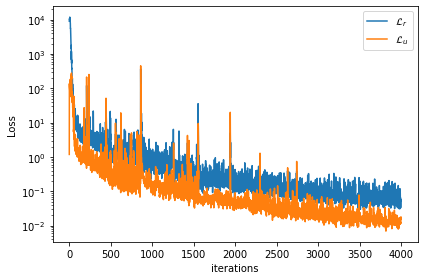

In [12]:

# Loss
loss_r = model.loss_r_log
loss_u = model.loss_u_log

fig_2 = plt.figure(2)
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(loss_r, label='$\mathcal{L}_{r}$')
ax.plot(loss_u, label='$\mathcal{L}_{u}$')
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


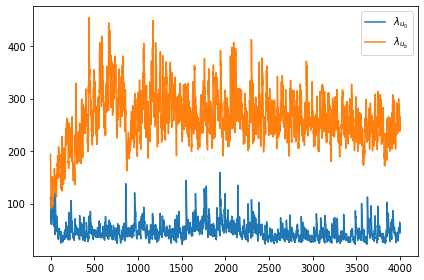

In [13]:

# Adaptive Constant
adaptive_constant_ics = model.adaptive_constant_ics_log
adaptive_constant_bcs = model.adaptive_constant_bcs_log

fig_3 = plt.figure(3)
ax = fig_3.add_subplot(1, 1, 1)
ax.plot(adaptive_constant_ics, label='$\lambda_{u_0}$')
ax.plot(adaptive_constant_bcs, label='$\lambda_{u_b}$')
plt.legend()
plt.tight_layout()
plt.show()

/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

AttributeError: 'NoneType' object has no attribute 'remove'

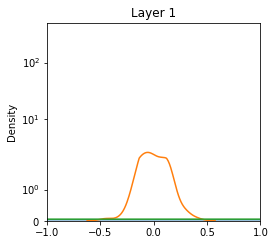

In [14]:


# Gradients at the end of training
data_gradients_ics = model.dict_gradients_ics_layers
data_gradients_bcs = model.dict_gradients_bcs_layers
data_gradients_res = model.dict_gradients_res_layers

num_hidden_layers = len(layers) - 1
cnt = 1
fig_4 = plt.figure(4, figsize=(13, 8))
for j in range(num_hidden_layers):
    ax = plt.subplot(2, 3, cnt)
    gradients_ics = data_gradients_ics['layer_' + str(j + 1)][-1]
    gradients_bcs = data_gradients_bcs['layer_' + str(j + 1)][-1]
    gradients_res = data_gradients_res['layer_' + str(j + 1)][-1]

    sns.distplot(gradients_ics, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \lambda_{u_0}\mathcal{L}_{u_0}$')
    sns.distplot(gradients_bcs, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \lambda_{u_b} \mathcal{L}_{u_b}$')
    sns.distplot(gradients_res, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \mathcal{L}_r$')

    ax.set_title('Layer {}'.format(j + 1))
    ax.set_yscale('symlog')
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 500])
    ax.get_legend().remove()
    cnt += 1
handles, labels = ax.get_legend_handles_labels()
fig_4.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.3, 0.01),
                borderaxespad=0, bbox_transform=fig_4.transFigure, ncol=3)
plt.tight_layout()
plt.show()

In [ ]:


# Eigenvalues of Hessian of losses if applicable
if stiff_ratio:
    eigenvalues_list = model.eigenvalue_log
    eigenvalues_ics_list = model.eigenvalue_ics_log
    eigenvalues_bcs_list = model.eigenvalue_bcs_log
    eigenvalues_res_list = model.eigenvalue_res_log

    eigenvalues_ics = eigenvalues_ics_list[-1]
    eigenvalues_bcs = eigenvalues_bcs_list[-1]
    eigenvalues_res = eigenvalues_res_list[-1]

    fig_5 = plt.figure(5)
    ax = fig_5.add_subplot(1, 1, 1)
    ax.plot(eigenvalues_ics, label='$\mathcal{L}_{u_0}$')
    ax.plot(eigenvalues_bcs, label='$\mathcal{L}_{u_b}$')
    ax.plot(eigenvalues_res, label='$\mathcal{L}_r$')
    ax.set_xlabel('index')
    ax.set_ylabel('eigenvalue')
    ax.set_yscale('symlog')
    plt.legend()
    plt.tight_layout()
    plt.show()
















